Dou et al. (2020) model

Agora em Julia versão 1.5.3

This script simulates the model

In [8]:
using Distributed
nprocs = 2
addprocs(nprocs)

2-element Array{Int64,1}:
 4
 5

In [9]:
pids = workers()

4-element Array{Int64,1}:
 2
 3
 4
 5

In [10]:
@everywhere using LinearAlgebra, Statistics

@everywhere using DataFrames

### Criando funções para simular o jogo

In [11]:
@everywhere function solve_tree(data, game_parameters, grid=100, hlow=0.01, hhigh=1.0, grid_payment=1000)
    
#     #data ####
#     #all the data is escalated so as to D = 1.0
    Vmax = data[1]; #firm's maximum reorganization value
    L = data[2]; #firm's maximum liquidation value
    Dj = data[3]; #junior's debt face value
    Ds = 1.0 - Dj; #senior's debt face value

    D = Ds + Dj; #total debt, used to escale costs

#     #parameters####
#     #parameters include only the parameters necessary to calculate the model, so it does not include θs0, θj0, μ
    ρ = game_parameters[1]; # (1 - ρ) is the firm's depreciation rate each period
    β = game_parameters[2]; #inverse of the speed of learning
    c0 = game_parameters[3]; #fixed cost of going to court
    λj = game_parameters[4]; #chance of j being called to propose at each period

    #c1 is calibrated. We will start with the same c1 as Dou et al.(2019)
    c1 = Float64(0.0015); #variable cost for each period at court
    #Initial definitions: costs, maximum value of the firm, maximum number of periods####


    #number of periods
    function max_turns(Vmax, L, ρ)
        t = 0

        #using the specification of the theoretical model
        #we are not considering the change in indexation from t to t+1 yet.
        while(ρ^(t-1) * Vmax > L)
            t = t+1
        end
        return t
    end


    T = max_turns(Vmax, L, ρ)


    #cost function
    function Ct(t, c0=c0, c1=c1)
        #cost at period t=0(index1) is 0
        if(t <= 1)
            return 0
        else
            return c0 * D + c1 * (t-1) * D #test to make index==1 be t==0
        end
    end

    #maximum value of reorganization each period
    function Vt(Vmax, ρ, t)

        if(t <=1)
            return Vmax
        else
            #(t-2) instead of (t-1) because we shifted the indexes in the game so as to include t==0 at index==1
            return ρ^(t-2) * Vmax
        end


    end
    #index 1 corresponds to t=0 and 2 to t=1...

    #liquidation payoffs

    function s_L(t)
        return min(L - Ct(t), Ds)
    end

    function j_L(t)
        return min(L - Ct(t) - s_L(t), Dj)
    end



    #grid size
    grid = grid

    hlow = hlow
    hhigh = hhigh


    hvals = LinRange(hlow, hhigh, grid)



    #array to tell the size of the pie at period t, according to reorganization skill levels
    #arguments: (period, θkt)
    U = Array{Float64}(undef, T+1, grid)


    for t in 1:T+1
        for h in 1:grid
            U[t,h] = hvals[h] * Vt(Vmax, ρ, t) - Ct(t)
        end
    end

    #cumulative distribution function
    function cdf(x, lt, β=β)

        #return the cdf of x given the lower bound lt
        #geq than 1 because of our discretization method 
        if(x >= 1.0)

            return 1.0

        else

            if(x >= lt)
                return 1.0 - ((1.0-x)^β)/((1-lt)^β)
            else
                return 0.0
            end
        end
    end


    #pmf: each point of the grid is at the center of the cdf
    function pmf_cdf(lt, δ = hlow/2, β=β)
        pmf = zeros(grid)

        for (i, h) in enumerate(hvals)
            pmf[i] = cdf(h+δ, lt) - cdf(h-δ, lt)
        end

        return pmf
    end



    #generating the pmfs

    #probability mass function
    pmf = Array{Float64}(undef,grid,grid)

    δ = hlow/2
    for (i, htoday) in enumerate(hvals)
        for (j, htomorrow) in enumerate(hvals)
            pmf[i,j] = cdf(htomorrow+δ, htoday) - cdf(htomorrow-δ, htoday)
        end
    end
    


    #we need a pmf for when we have lkt and want to know θk,t+1
    #we will call it 'pmf2'
    pmf2 = similar(pmf)

    for i in eachindex(hvals)
        for j in eachindex(hvals)
            pmf2[i, j] = sum(pmf[i, :] .* pmf[:, j])
        end
    end



    #continuation values
    #period t (not t+1), θkt, ℓkt, ℓmt
    s_W = zeros(T+1, grid, grid, grid);
    j_W = similar(s_W);


    #optimal payments
    #period, θkt, ℓmt, outputs
    Pst_array = zeros(T, grid, grid, 6); #we won't need payment proposal for period T, a.k.a. "T+1"
    Pjt_array = similar(Pst_array);

    #populating the last period with the liquidation values
    s_W[T+1, :, :, :] .= s_L(T+1); #we need to use .= because it is a broadcast
    j_W[T+1, :, :, :] .= j_L(T+1);

    #function to select the pmf function as it is writen in the paper

    function populate_probm!(t, lmt, probm, pmf, pmf2, grid)
        #takes the indexes of cutoff and lmt

        #at t=0(index 1), all information is symmetric, so we use pmf instead of pmf2
        if(t <= 1)

            for i in 1:grid
                probm[i] = pmf[lmt, i]
            end

        else

            for i in 1:grid
                probm[i] = pmf2[lmt, i]
            end

        end
    end



    #cutoff function: upgrade

    function getcutoff_manual(t, pkt, hkt, m_W, grid)


        cmt=Int64(1)

        while(m_W[t+1, cmt, cmt, hkt] < pkt)
            cmt+=1

            #break if cmt==grid+1
            if(cmt==grid+1)
                return cmt
            end

        end

        return cmt
    end



    #function to "filter" the cutoff

    function cutoff_manual(t, pkt, hkt, lmt, m_W, grid)
        #for now, it will just tell us if the payment offer is negative

        #if payment is negative (waiting offer), the cutoff will be 102 (grid+2), a code for the adversary to always reject it
        if(pkt<0)
             return grid+2
        end

        cmt = getcutoff_manual(t, pkt, hkt, m_W, grid)

        return cmt


    end


    function dot_W(t, hkt, lkt, lmt, grid, k_W, pmf)

        #calculates the dot product between k_W and pmf

        payoff=0.0
        @inbounds for i in hkt:grid
            payoff+= k_W[t+1, i, lkt, lmt] * pmf[hkt, i]
        end
        return payoff
    end

    #lkt+1 = hkt, so we input it here

    function dot_U(t, hkt, grid, U, pkt, pmf)

        #calculates the dot product between U and pmf
        payoff=0.0
        @inbounds for i in hkt:grid
            payoff+= (U[t, i] - pkt) * pmf[hkt, i]
        end
        return payoff
    end

    function compute_payoff_pkt!(t, payoff, pmf, probm, k_W, m_W, share, U, hkt, lmt, Vmax, grid)

        @inbounds for i in 1:(length(share)+1)

            if(i==1)
                pkt = -Vmax
            else
                pkt = U[t, hkt] * share[i-1]
            end    

            cmt = cutoff_manual(t, pkt, hkt, lmt, m_W, grid)

            if(cmt==grid+2) 
                #means that pkt<0, so it will be always rejected
                #lmt+1 == lmt
                payoff[i] += dot_W(t, hkt, hkt, lmt, grid, k_W, pmf)



            elseif(cmt == grid+1) 
                #means that cutoff doesn't exist, so the payment offer will be accepted by all θmt+1

                #since sum(probm[lmt:grid])==1, we didn't include it here
                payoff[i] += dot_U(t, hkt, grid, U, pkt, pmf)

            else
                #cases where cmt is between 1 and grid

                if(cmt < lmt)
                    #means that pkt<minimum continuation value of m, so it will be always rejected
                    #similar to pkt<0
                    #lmt+1 == lmt
                    payoff[i] += dot_W(t, hkt, hkt, lmt, grid, k_W, pmf)

                elseif(cmt==lmt)

                    #accepted only if hmt+1==lmt
                    payoff[i] += dot_U(t, hkt, grid, U, pkt, pmf) * probm[lmt]

                    #rejected otherwise
                    payoff[i] += dot_W(t, hkt, hkt, lmt, grid, k_W, pmf) * sum(@view(probm[(lmt+1):grid]))

                else
                    #cmt > lmt
                    #accepted if hmt+1 <=cmt
                    payoff[i] += dot_U(t, hkt, grid, U, pkt, pmf) * sum(@view(probm[lmt:cmt]))


                    #rejected otherwise
                    #lmt+1 = cmt
                    payoff[i] += dot_W(t, hkt, hkt, cmt, grid, k_W, pmf) * sum(@view(probm[(cmt+1):grid]))

                end
            end
        end
    end

    grid_payment=grid_payment
    share = LinRange(hlow, hhigh-hlow, grid_payment)

    #testing cutoff in this newer version of Pkt

    #function to calculate the optimal payment offer and directly populate the array

    function Pkt!(t, hkt, lmt, k_W, m_W, k_L, Pkt_array, pmf, pmf2, share, U, Vmax=Vmax, grid=grid)


    #     Pkt_grid = Vector{Float64}(undef, length(share)+1)

    # #     Pkt_grid = zeros(length(share)+1)

    #     #the first input is -Vmax, to assure that m will reject all offers. It is the waiting payoff
    #     Pkt_grid[1] = -Vmax

    #     #t+1 is just because we have T+1 periods in U, so U[1] is t==0 and U[T] is t==T-1
    #     #the reorganization payoff is U_{t} (\theta_{t+1})
    #     Pkt_grid[2:end] .=  U[t, hkt] .* share

        #pmf of m is a function of t (at t=0 (index 1), the information is symmetric)
        #array: pmf[lmt, 1:end] or pmf2[lmt, 1:end]
        probm = zeros(grid)
        populate_probm!(t, lmt, probm, pmf, pmf2, grid)

        payoff = zeros(length(share)+1)
        compute_payoff_pkt!(t, payoff, pmf, probm, k_W, m_W, share, U, hkt, lmt, Vmax, grid)

        #payoffs matrix####

        payoff_reorg, index_reorg = findmax(payoff)

        if(index_reorg==1)
                payment = -Vmax
            else
                payment = U[t, hkt] * share[index_reorg-1]
            end    


        #calculating the optimal policy between liquidating, reorganizing or waiting ####
        payoff_liq = k_L(t)

        #waiting payoff is associated with the first possible payment, the waiting offer(-Vmax)
        payoff_wait = payoff[1]

        payoff_max, policy = findmax((payoff_liq, payoff_wait, payoff_reorg))



        #populates the array
        Pkt_array[t, hkt, lmt, :] .= payment, cutoff_manual(t, payment, hkt, lmt, m_W, grid), payoff_reorg, payoff_wait, payoff_max, policy

    end





    #optimal proposal
    function propose(t, hkt, lkt, lmt, Pkt_array)


        #it just searches for the corresponding Pkt
        payoff_max, policy = @views Pkt_array[t, hkt, lmt, end-1:end]

        return payoff_max, policy
    end


    #"cdf" for the discretized distribution
    function cdf_discrete(x, lt, pmf)

        #returns the probability that θt takes a value less than or equal to x, given lt
        #if needed, ie in threshold, we can just subtract 0.01 from x, so cdf_discrete the prob that θt < x, strictly
        return sum(@view(pmf[lt, lt:x]))
    end



    #function to calculate the payment offer threshold ϕmt

    function threshold_m(t, lkt, lmt, Pmt_array)

        #searches the index where the optimal policy is either 2.0 or 3.0 (wait or reorganize)
        #"Return the index of the first value in a greater than or equal to x, according to the specified order. 
        #Return length(a) + 1 if x is greater than all values in a. a is assumed to be sorted."
        ts = @views searchsortedfirst(Pmt_array[t, :, lkt, end], 2.0)


        #returns error message if threshold does not exist (101 is returned if missing by searchsortedfirst)
#         @assert ts < 101 "ρ=$ρ, c0=$c0"
        #removed @assert because it is not necessary to calculate the equilibrium of the game

        return ts

    end


    function prob_liq_m(t, ts, lmt, pmf)

        #probability that m will propose liquidation next period

        #at t==0 (index 1), the info is symmetric, so lmt == θmt, thus it becomes the indicator function
        if(t<=1)
            if(lmt >= ts)
                return 0.0
            else
                return 1.0
            end


        else#if t>0(index>1)

            if(lmt >= ts)
                return 0.0
            else
                return cdf_discrete(ts-1,lmt, pmf) #we subtract 1 because we want prob(θt < ts)
            end

        end


    end


    function dot_W2(t, hkt, hkt_next, lkt, lmt, grid, k_W, pmf)

        #calculates the dot product between k_W and pmf
        #modified to include hkt_next, to use in respond_payment

        payoff=0.0
        @inbounds for i in hkt_next:grid
            payoff+= k_W[t+1, i, lkt, lmt] * pmf[hkt, i]
        end
        return payoff
    end

    # function compute_payoff2!(t, payoff, Pkt_grid, cmt, pmf, probm, k_W, m_W, U, hkt, lmt, grid=grid)

    function compute_payoff_pmt(t, Pmt_array, pmf, k_W, hkt, lkt, lmt, grid=grid)


        payoff=zero(0.0)


        @inbounds for lmt_next in lmt:grid
            pmt = Pmt_array[t, lmt_next, lkt, 1]
            ckt = Int64(Pmt_array[t, lmt_next, lkt, 2])

            if(ckt==grid+2)
                #means that the payment offer is negative (waiting offer)
                #the proposal will be rejected for sure, without lowerbound update
    #             payoff += dot(@view(k_W[t+1, hkt:end, lkt, lmt_next]), @view(pmf[hkt, hkt:end])) * pmf[lmt, lmt_next]
                payoff += dot_W2(t, hkt, hkt, lkt, lmt_next, grid, k_W, pmf) * pmf[lmt, lmt_next]


            elseif(ckt==grid+1)
                #means that there is no cutoff, K will accept the payment offer for all θkt+1
    #             payoff += pmt * sum(@view(pmf[hkt, hkt:end])) * pmf[lmt, lmt_next]
                payoff += pmt * pmf[lmt, lmt_next]

            else

                if(ckt < lkt)
                    #the proposal will be rejected for sure, without lowerbound update
    #                 payoff += dot(@view(k_W[t+1, hkt:end, lkt, lmt_next]), @view(pmf[hkt, hkt:end])) * pmf[lmt, lmt_next]

                    payoff += dot_W2(t, hkt, hkt, lkt, lmt_next, grid, k_W, pmf) * pmf[lmt, lmt_next]


                elseif(ckt==lkt)
                    #will accept only if hkt+1==lkt
                    payoff += pmt * pmf[hkt, lkt] * pmf[lmt,lmt_next]

                    #rejects otherwise
    #                 payoff += dot(@view(k_W[t+1, lkt+1:end, lkt, lmt_next]), @view(pmf[hkt, lkt+1:end])) * pmf[lmt, lmt_next]

                    payoff+= dot_W2(t, hkt, lkt+1, lkt, lmt_next, grid, k_W, pmf) * pmf[lmt, lmt_next]


                else
                #now ckt > lkt

                    if(ckt < hkt)
                        #he rejects, but there is an update in the lowerbound lkt+1==ckt
    #                     payoff += dot(@view(k_W[t+1, hkt:end, ckt, lmt_next]), @view(pmf[hkt, hkt:end])) * pmf[lmt, lmt_next]

                        payoff += dot_W2(t, hkt, hkt, ckt, lmt_next, grid, k_W, pmf) * pmf[lmt, lmt_next]

                    else

                        #receives pmt if his skill level is below or equal to the cutoff
                        payoff += pmt * sum(@view(pmf[hkt, hkt:ckt])) * pmf[lmt, lmt_next]


                        #receives continuation value k_W if his skill level greather than the cutoff
    #                     payoff += dot(@view(k_W[t+1, ckt+1:end , ckt, lmt_next]), @view(pmf[hkt, ckt+1:end])) * pmf[lmt, lmt_next]


                        payoff+= dot_W2(t, hkt, ckt+1, ckt, lmt_next, grid, k_W, pmf) * pmf[lmt, lmt_next]

                    end
                end
            end
        end


        return payoff
    end



    #expected payoff of answering a payment proposal

    function respond_payment(t, hkt, lkt, lmt, Pmt_array, k_W, pmf, grid=grid)


        #the minimum level of hmt necessary for m to offer a payment
        #it will be used as hmt
        ts = threshold_m(t, lkt, lmt, Pmt_array)

        #updated lower bound
        lmt = max(ts, lmt)

        return compute_payoff_pmt(t, Pmt_array, pmf, k_W, hkt, lkt, lmt, grid)

    end




    # quase mesma função que foi criada para acelerar Pkt!(), mas aqui não subtrai pkt
    function dot_U2(t, hkt, grid, U, pmf)

        #calculates the dot product between U and pmf
        payoff=0.0
        @inbounds for i in hkt:grid
            payoff+= U[t, i] * pmf[hkt, i]
        end
        return payoff
    end

    #expected payoff of answering a liquidation proposal

    function respond_liq(t, hkt, lkt, lmt, k_L, m_L, pmf, U, grid=grid)

        #payoff_reorg is the payoff of reorganizing while paying the opponent's liquidation value
        #U_{t} (\theta_{t+1}) because the skill level is of the next period
        #dot is matrix multiplication
        payoff_reorg = dot_U2(t, hkt, grid, U, pmf) - m_L(t)

        payoff_liq = k_L(t)

        return max(payoff_liq, payoff_reorg)
    end



    # @code_warntype respond_liq(t, hkt, lkt, lmt, k_L, m_L)

    #expected payoff of being called to respond
    function respond(t, hkt, lkt, lmt, Pmt_array, k_W, k_L, m_L, pmf, U, grid=grid)

        probm_liq = prob_liq_m(t, threshold_m(t, lkt, lmt, Pmt_array), lmt, pmf)


        return (1.0 - probm_liq) * respond_payment(t, hkt, lkt, lmt, Pmt_array, k_W, pmf) + probm_liq * respond_liq(t, hkt, lkt, lmt, k_L, m_L, pmf, U, grid)
    end
    
    
    function populate_pkt_manual!(t, s_W, j_W, s_L, j_L, Pst_array, Pjt_array, pmf, pmf2, share, U, Vmax, grid)

        @inbounds for l in 1:grid
            for h in 1:grid
                Pkt!(t, h, l, s_W, j_W, s_L, Pst_array, pmf, pmf2, share, U, Vmax, grid) #Pst
                Pkt!(t, h, l, j_W, s_W, j_L, Pjt_array, pmf, pmf2, share, U, Vmax, grid) #Pjt
            end
        end

    end

    function populate_wkt_manual!(t, s_W, j_W, s_L, j_L, Pst_array, Pjt_array, pmf, pmf2, share, U, grid)

        for lm in 1:grid
            for lk in 1:grid
               for hk in lk:grid #populates only if hk >= lk, saving time
                    s_W[t, hk, lk, lm] = λj * respond(t, hk, lk, lm, Pjt_array, s_W, s_L, j_L, pmf, U) + (1-λj) * propose(t, hk, lk, lm, Pst_array)[1]
                    j_W[t, hk, lk, lm] = λj * propose(t, hk, lk, lm, Pjt_array)[1] + (1-λj) * respond(t, hk, lk, lm, Pst_array, j_W, j_L, s_L, pmf, U)

                end
            end
        end
    end


    function populate_periods_manual!(tfinal, tbegin, s_W, j_W, s_L, j_L, Pst_array, Pjt_array, pmf, pmf2, share, U, Vmax, grid)

        @time begin


            for t in tfinal:-1:tbegin

                #populating Pkt
                populate_pkt_manual!(t, s_W, j_W, s_L, j_L, Pst_array, Pjt_array, pmf, pmf2, share, U, Vmax, grid)

                #populating Wkt
                populate_wkt_manual!(t, s_W, j_W, s_L, j_L, Pst_array, Pjt_array, pmf, pmf2, share, U, grid)

            end

        end

    end

   ### Populating the whole game
    populate_periods_manual!(T, 1, s_W, j_W, s_L, j_L, Pst_array, Pjt_array, pmf, pmf2, share, U, Vmax, grid)

    
    ### returns the arrays necessary to simulate the game
    return s_W, j_W, Pst_array, Pjt_array, Ds, Dj
    
end


In [12]:
@everywhere function simulate_moments(S, N, game_parameters, simulation_parameters, data1, data2, A1, A2, n1)


    Results = loop_simulations(S, N, game_parameters, simulation_parameters, data1, data2, A1, A2, n1)

    Moments = zeros(S, 8)

    μ = simulation_parameters[3]
    for s in 1:S

            DF = DataFrame()
            DF.payoff_s = Results[s,:,1];
            DF.payoff_j = Results[s,:,2];
            DF.out = Results[s,:,3];
            DF.t = Results[s,:,4];
            DF.observed_proposals = Results[s,:,5];
            DF.Ds = Results[s,:,6];
            DF.Dj = Results[s,:,7];


            DF.outcome = ifelse.(DF.out .==3.0, "R", "L");


            #desfazendo o deslocamento no índice de t
            DF.t = DF.t .- 1.0;

            # DF.incourt = ifelse.(DF.t .> 0.0, "incourt", "precourt");

            INCOURT = filter(DF -> DF.t .> 0.0, DF);
            PRECOURT = filter(DF -> DF.t .<= 0.0, DF);

            PRECOURT_REORG = filter(PRECOURT -> PRECOURT.outcome .== "R", PRECOURT)
            INCOURT_REORG = filter(INCOURT -> INCOURT.outcome .== "R", INCOURT)

            #cálculo dos momentos
            #1. avg log number of months between observed proposals incourt

            mm1 = INCOURT
            mm1 = log.(mm1.t .* μ ./ mm1.observed_proposals)
            mm1 = mean(mm1)

            #2. fraction reorganized given that the case went into court

            mm2 = INCOURT
            mm2 = size(filter(mm2 -> mm2.outcome .== "R", mm2),1)/ size(mm2,1)

            #3. ln duration of court cases in months

            mm3 = INCOURT
            mm3 = filter(mm3 -> mm3.t .> 0.0, mm3) #removendo os casos 0 para não poluir a média
            mm3.t = mm3.t .* μ
            mm3 = mean(log.(mm3.t)) #log here uses exp as base, so it's the same as ln

            #4. fraction of cases incourt
            mm4 = size(INCOURT,1) / size(DF, 1)

            #5. avg recovery rate for senior given precourt REORGANIZATION

            #aqui nós temos Ds, então é mais fácil. Preciso automatizar isso no código quando for tudo escalado

            mm5 = PRECOURT_REORG
            mm5.R_s = mm5.payoff_s ./ mm5.Ds
            mm5 = mean(mm5.R_s)



            #6. avg recovery rate for junior given precourt REORGANIZATION

            #aqui nós temos Ds, então é mais fácil. Preciso automatizar isso no código quando for tudo escalado

            mm6 = PRECOURT_REORG
            mm6.R_j = mm6.payoff_j ./ mm6.Dj
            mm6 = mean(mm6.R_j)


            #7. junior avg fraction gain given incourt REORGANIZATION

            mm7 = INCOURT_REORG
            mm7 = mean(mm7.payoff_j ./ (mm7.payoff_j .+ mm7.payoff_s )) 

            #8. total recovery rate given incourt REORGANIZATION

            mm8 = INCOURT_REORG
            mm8 = mean( mm8.payoff_s .+ mm8.payoff_j)


            Moments[s,:] .= [mm1, mm2, mm3, mm4, mm5, mm6, mm7, mm8]


            #if there are no INCOURT or no PRECOURT cases, it will return NaN
            #thus, we replace it by zero
            Moments[s,:] .= replace!(Moments[s,:], NaN=> zero(0.0))

        end
    return vec(mean(Moments, dims=1))
end


@everywhere function loop_simulations(S, N, game_parameters, simulation_parameters, data1, data2, A1, A2, n1)



    #S is the number of simulations
    #N is the number of observations
    #data1 is the center of the first cluster
    #A1 is the collection of arrays from the first cluster (s_W, j_W, Pst, Pjt)
    #n1 is the number of observations in the first cluster




    #no futuro os argumentos podem ser arrays de arrays, assim ele faz o loop para cada cluster
    Results = zeros(S, N, 7)

    #últimas entradas de Results são os valores das dívidas


    for s in 1:S
        for n in 1:N
            if(n <= n1)
                Results[s,n,1:5] .= simulate_game(data1, game_parameters, simulation_parameters, A1[1], A1[2], A1[3], A1[4])
                Results[s,n, end-1] = A1[5]
                Results[s,n, end] = A1[6]
            else
                Results[s,n,1:5] .= simulate_game(data2, game_parameters, simulation_parameters, A2[1], A2[2], A2[3], A2[4])
                Results[s,n, end-1] = A2[5]
                Results[s,n, end] = A2[6]
            end

        end
    end

    return Results

end



@everywhere function simulate_game(data, game_parameters, simulation_parameters, s_W=s_W, j_W=j_W, Pst_array=Pst_array, Pjt_array=Pjt_array, t=1, grid=100)


    Vmax = data[1]
    L = data[2]
    Dj = data[3]
    Ds = one(1.0) - Dj


    c0 = game_parameters[3];
    c1 = Float64(0.0015);

    ρ = game_parameters[1];
    λj = game_parameters[4];



#     hst = Hs0
#     hjt = Hj0

    hst = Int64(simulation_parameters[1])
    hjt = Int64(simulation_parameters[2])

    #assumindo que lower bounds nos períodos iniciais são as próprias habilidades iniciais
    lst = hst
    ljt = hjt

    result = zeros(5);

    #number of observed proposals
    observed_proposals = 0.0


    #recovering "T+1" from s_W 
    T = size(s_W,1)


    while(result[1]==0.0 && t < T)


        u = rand()

        if(u < λj)
            propositor = "j"

        else
            propositor = "s"

        end


        #setting the default variables according to the propositor
        Pkt_array, Cont_val, prop_index, respondent_index, m_L, hkt, lkt, hmt, lmt, lk_next, hk_next, hm_next = choose_parameters(propositor, hst, lst, hjt, ljt, Pst_array, Pjt_array, s_W, j_W)

        #proposal ####
        policy, payoff_prop, payment, lm_next = proposal(Pkt_array, t, hkt, lmt)

        #lm_next is the update of the adversary's lower bound
        if(lm_next>=grid+1 || policy!= 3.0) #para evitar update de lowerbound quando proponente não propõe reorg
            lm_next = lmt
        else
            lm_next = Int64(lm_next)
        end



        if(policy==3.0)

            observed_proposals += 1.0

            payoff_respondent, answer = answer_reorg(payment, Cont_val, t, hm_next, lm_next, lk_next)


            if(answer==1.0)

                result[prop_index] = payoff_prop
                result[respondent_index] = payoff_respondent
                result[3] = 3.0
                result[4] = t
                result[5] = observed_proposals

            else

                t+=1

                hst, lst, hjt, ljt = update_beliefs(propositor, hk_next, hm_next, lk_next, lm_next)
            end

        elseif(policy==2.0)

            t+=1

            hst, lst, hjt, ljt = update_beliefs(propositor, hk_next, hm_next, lk_next, lm_next)



        else      
            #(policy==1.0)

            observed_proposals += 1.0

            payoff_respondent, answer = answer_liq(m_L, t, hm_next, payoff_prop, L, Ds, Dj, Vmax, ρ, c0, c1)



            if(answer==1.0)

                result[prop_index] = payoff_prop
                result[respondent_index] = payoff_respondent
                result[3] = 1.0
                result[4] = t
                result[5] = observed_proposals

            else

                result[prop_index] = payoff_prop
                result[respondent_index] = payoff_respondent
                result[3] = 3.0
                result[4] = t
                result[5] = observed_proposals


            end
        end


        if(t==T)

            result[1] = s_W[T, 1, 1, 1]#todos os valores finais de S são iguais, então acessarei o índice 1
            result[2] = j_W[T, 1, 1, 1]
            result[3] = 1.0
            result[4] = t
            result[5] = max(observed_proposals, 1.0)

        end





    end


    return result
end

@everywhere function choose_parameters(propositor, hst, lst, hjt, ljt, Pst_array, Pjt_array, s_W, j_W)

    if(propositor=="s")

        Pkt_array = Pst_array
        Cont_val = j_W
        prop_index = 1
        respondent_index = 2 #índice de j, para organizar o payoff
        m_L = j_L

        hkt = hst
        lkt = lst

        hmt = hjt
        lmt = ljt


        lk_next = hkt

        hk_next = draw_beta(hkt)
        hm_next = draw_beta(hmt)

    elseif(propositor=="j")
        Pkt_array = Pjt_array
        Cont_val = s_W
        prop_index = 2
        respondent_index = 1
        m_L = s_L

        hkt = hjt
        lkt = ljt

        hmt = hst
        lmt = lst


        lk_next = hkt


        hk_next = draw_beta(hkt)
        hm_next = draw_beta(hmt)

    else

        println("error: propositor not valid")

    end

    return Pkt_array, Cont_val, prop_index, respondent_index, m_L, hkt, lkt, hmt, lmt, lk_next, hk_next, hm_next
end


@everywhere function draw_beta(hkt, β=game_parameters[2], grid=100)

    u = rand()

    if(hkt == grid)

        return grid

    else

        x = 1.0 - exp(1.0/β * (log(1.0 - u) + β * log(1.0 - hkt/grid)))
        x = round(x * grid, digits=0)
#         return Int64(x * 100) #to convert in an integer
        return Int64(x)

    end
end


#cost @everywhere function
@everywhere function Ct(t, c0=c0, c1=c1)

    #didn't use D because is normalized to D == 1.0
    #cost at period t=0(index1) is 0
    if(t <= 1)
        return 0
    else
        return c0 + c1 * (t-1) #test to make index==1 be t==0
    end
end



#liquidation payoffs
@everywhere function s_L(t, L, Ds, Dj, c0, c1)
    return min(L - Ct(t, c0, c1), Ds)
end


@everywhere function j_L(t, L, Ds, Dj, c0, c1)
    return min(L - Ct(t, c0, c1) - s_L(t, L, Ds, Dj, c0, c1), Dj)
end


@everywhere function proposal(Pkt_array, t, hkt, lmt)

    #pkt array será sempre do propositor, quem responder às propostas apenas olhará o seu valor de continuação

    return policy, payoff_prop, payment, lm_next = Pkt_array[t, hkt, lmt, [end,end-1, 1, 2]]

end


#maximum value of reorganization each period
@everywhere function Vt(Vmax, ρ, t)

    if(t <=1)
        return Vmax
    else
        #(t-2) instead of (t-1) because we shifted the indexes in the game so as to include t==0 at index==1
        return ρ^(t-2) * Vmax
    end


end

# answer_liq
@everywhere function answer_liq(m_L, t, hm_next, payoff_prop, L, Ds, Dj, Vmax, ρ, c0, c1)

    liq = (m_L(t, L, Ds, Dj, c0, c1), Vt(Vmax, ρ, t) * hm_next/100 - Ct(t, c0, c1) - payoff_prop)

    payoff_liq, answer = findmax(liq)

    return payoff_liq, answer
end

@everywhere function answer_reorg(payment, Cont_val, t, hm_next, lm_next, lk_next)

    reorg_value = (payment, Cont_val[t+1, hm_next, lm_next, lk_next])

    payoff_reorg, answer = findmax(reorg_value)

    return payoff_reorg, answer
end

@everywhere function update_beliefs(propositor, hk_next, hm_next, lk_next, lm_next)

    if(propositor=="s")
        hst = hk_next
        lst = lk_next

        hjt = hm_next
        ljt = lm_next

    else
        hst = hm_next
        lst = lm_next

        hjt = hk_next
        ljt = lk_next
    end


    return hst, lst, hjt, ljt
end

In [13]:
#Vh/D, L/D, Dj/D
data1 = [0.86, 0.19, 0.8];
n1 = 49

data2 = [2.65, 0.69, 0.74];
n2 = 17

#ρ, β, c0, λj
game_parameters = [0.884, 9.84, 0.04, 0.346];

#θs0, θj0, μ
simulation_parameters = [28.0, 36.0, 4.566];

In [14]:
aux = pids[2]


A2 = @spawnat aux solve_tree(data2, game_parameters)

A1 = solve_tree(data1, game_parameters);

A2 = fetch(A2);

111.210756 seconds (402.24 M allocations: 8.927 GiB      From worker 3:	109.040280 seconds (344.38 M allocations: 7.647 GiB, 1.13% gc time)
, 1.42% gc time)


([0.31459967699288827 0.31783566269691543 … 2.2588231445104836 2.28868137388897; 0.2959541712000613 0.2980138644627734 … 2.220810483634086 2.249483452946722; … ; 0.26000000000005685 0.26000000000005685 … 0.35400172229517357 0.361844727319939; 0.26 0.26 … 0.26 0.26]

[0.0 0.31783566269691543 … 2.2588231445104836 2.28868137388897; 0.0 0.29810095034281825 … 2.220859377467023 2.249533353091562; … ; 0.0 0.26000000000005685 … 0.35400172229517357 0.361844727319939; 0.26 0.26 … 0.26 0.26]

[0.0 0.0 … 2.2588231445104836 2.28868137388897; 0.0 0.0 … 2.220878522376092 2.249552860411204; … ; 0.0 0.0 … 0.35400172229517357 0.361844727319939; 0.26 0.26 … 0.26 0.26]

...

[0.0 0.0 … 2.2588231445104836 2.28868137388897; 0.0 0.0 … 2.230280499952681 2.2590216903587486; … ; 0.0 0.0 … 0.35400172229517357 0.361844727319939; 0.26 0.26 … 0.26 0.26]

[0.0 0.0 … 2.2588231445104836 2.28868137388897; 0.0 0.0 … 2.230280775068659 2.259021972499694; … ; 0.0 0.0 … 0.35400172229517357 0.361844727319939; 0.26 0.26 … 0.2

In [20]:
@everywhere using Random

@everywhere Random.seed!(2021)

#test
S = 40
N = 66

simulated_moments = simulate_moments(S, N, game_parameters, simulation_parameters, data1, data2, A1, A2, n1)

8-element Array{Float64,1}:
 1.3621994561882225
 1.0
 2.31073739820805
 0.29810606060606054
 0.8709474905433602
 0.24847429439657348
 0.43253572237420296
 0.9032959151776611

In [39]:
function moments_variation(S, N, game_parameters, simulation_parameters, data1, data2, n1, aux, parameter, ub, lb)
    
    #calcula todos os momentos variando um parâmetro e deixando os demais fixos
    
    #parameter é um número entre 1 e 7 indicando qual parâmetro iremos variar
    
    #número de pontos nos quais calcularemos cada parâmetro
    npoints = 10
    
    
    #cada linha é uma dos 10 pontos onde o parâmetro será calculado
    #cada coluna é um momento
    MM = zeros(npoints,8)
    
    
    baseline_game_parameters = game_parameters
    baseline_simulation_parameters = simulation_parameters
    
    delta = (ub - lb)/(npoints-1)
    
    if(parameter<=size(game_parameters,1))
        
        for i in 1:npoints  
            game_parameters[parameter] = lb + delta * (i-1)
            
            A2 = @spawnat aux solve_tree(data2, game_parameters)

            A1 = solve_tree(data1, game_parameters);

            A2 = fetch(A2);

            MM[i, :] .= simulate_moments(S, N, game_parameters, simulation_parameters, data1, data2, A1, A2, n1)
            
        end
            
    else
        A2 = @spawnat aux solve_tree(data2, baseline_game_parameters)

        A1 = solve_tree(data1, baseline_game_parameters);

        A2 = fetch(A2);
        
        for i in 1:npoints
            
            simulation_parameters[parameter - size(game_parameters, 1)] = lb + delta * (i-1)
            
            MM[i, :] .= simulate_moments(S, N, game_parameters, simulation_parameters, data1, data2, A1, A2, n1)
        end

    end
    
    return MM
    
end
        
    

moments_variation (generic function with 1 method)

In [40]:
#bounds for g
lg = [0.4, 1.0, 0.01, 0.01]
ug = [0.93, 48.0, 0.6, 0.99]
#ρ was limited at 0.93 because a higher value would create more periods and calculations would take longer than we could afford.


#bounds for s
#μ can be 0.5 month or 18 months
ls = [1, 1, 0.5] 
us = [50, 50, 16]

3-element Array{Int64,1}:
 50
 50
 16

In [41]:
parameter = 1
ub = ug[parameter]
lb = lg[parameter]


SP1 = moments_variation(S, N, game_parameters, simulation_parameters, data1, data2, n1, aux, parameter, ub, lb)

 23.766059 seconds (83.73 M allocations: 1.874 GiB, 1.73% gc time)
      From worker 3:	 25.764867 seconds (83.73 M allocations: 1.874 GiB, 1.52% gc time)
 27.464565 seconds (83.73 M allocations: 1.874 GiB, 2.18% gc time)
      From worker 3:	 29.711516 seconds (83.73 M allocations: 1.874 GiB, 1.46% gc time)
 24.189763 seconds (112.66 M allocations: 2.514 GiB, 2.19% gc time)
      From worker 3:	 28.662187 seconds (112.66 M allocations: 2.514 GiB, 1.52% gc time)
 23.717088 seconds (112.66 M allocations: 2.514 GiB, 2.25% gc time)
      From worker 3:	 27.000899 seconds (112.66 M allocations: 2.514 GiB, 1.05% gc time)
 27.238441 seconds (141.59 M allocations: 3.154 GiB, 2.34% gc time)
      From worker 3:	 29.384126 seconds (112.66 M allocations: 2.514 GiB, 1.40% gc time)
 33.723116 seconds (170.52 M allocations: 3.794 GiB, 2.20% gc time)
      From worker 3:	 37.452193 seconds (141.59 M allocations: 3.154 GiB, 1.38% gc time)
 36.085247 seconds (199.45 M allocations: 4.434 GiB, 2.21% gc 

10×8 Array{Float64,2}:
 1.26005   1.0  1.72062  0.19697   1.58973   0.737316  0.483021  0.984867
 1.26556   1.0  1.75659  0.201515  1.51019   0.750865  0.471208  0.951156
 1.36734   1.0  1.84953  0.177652  0.975649  0.868305  0.331589  1.04666
 0.987854  1.0  1.88825  0.168939  1.07392   0.855229  0.506327  1.00995
 0.997473  1.0  1.96943  0.119318  0.907401  0.890231  0.554297  1.35725
 1.00133   1.0  2.00362  0.130303  0.825086  0.886855  0.52929   1.38488
 1.48424   1.0  2.05944  0.138636  0.822969  0.878916  0.55985   1.38647
 1.48908   1.0  2.17086  0.123864  0.8752    0.889575  0.557205  1.36444
 1.52095   1.0  2.33802  0.114394  0.893606  0.902012  0.647556  1.35519
 1.55388   1.0  2.58538  0.121212  0.76356   0.930015  0.850357  1.43231

In [42]:
using DelimitedFiles

writedlm( "SP1.csv",  SP1, ',')

Gráfico com as variações dos momentos em relação ao parâmetro

In [57]:
function plot_moment(parameter, moment, Data)
    
    
    X = LinRange(lb, ub, size(Data,1))
    
    p = plot()
    
    push!(p, layer(x=X, y = Data[:,moment], Geom.line))


    push!(p, Guide.xlabel("Parameter $parameter"))
    push!(p, Guide.ylabel("Moment $moment"))
    push!(p, Guide.title("Variation of Moment $moment as a function of Parameter $parameter"))

    ticksx = X
    push!(p, Guide.xticks(ticks=ticksx))
    
end
    
    

plot_moment (generic function with 1 method)

In [75]:
using Cairo, Fontconfig

┌ Info: Precompiling Cairo [159f3aea-2a34-519c-b102-8c37f9878175]
└ @ Base loading.jl:1278
┌ Info: Precompiling Fontconfig [186bb1d3-e1f7-5a2c-a377-96d770f13627]
└ @ Base loading.jl:1278


In [76]:
for i in 1:size(SP1, 2)
    
    p1 = plot_moment(parameter, i, SP1)
    name = string("p1", "$i", ".png")
    
    draw(PNG(name, dpi=400), p1)
end


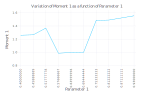

In [60]:
p1 = plot_moment(parameter, moment, SP1)

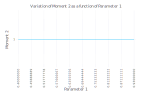

In [61]:
p2 = plot_moment(parameter, 2, SP1)

### Parâmetro 2, 3, falta o 4

In [99]:
parameter = 4
ub = ug[parameter]
lb = lg[parameter]


Data = moments_variation(S, N, game_parameters, simulation_parameters, data1, data2, n1, aux, parameter, ub, lb)



using DelimitedFiles

writedlm( "SP4.csv",  Data, ',')

139.276518 seconds (633.40 M allocations: 14.035 GiB, 4.05% gc time)
      From worker 3:	166.061659 seconds (575.54 M allocations: 12.754 GiB, 3.54% gc time)
168.153101 seconds (633.40 M allocations: 14.035 GiB, 27.30% gc time)
      From worker 3:	194.932809 seconds (575.54 M allocations: 12.754 GiB, 23.97% gc time)
127.923728 seconds (633.40 M allocations: 14.035 GiB, 2.55% gc time)
      From worker 3:	153.495656 seconds (575.54 M allocations: 12.754 GiB, 1.67% gc time)
136.024884 seconds (633.40 M allocations: 14.035 GiB, 2.13% gc time)
      From worker 3:	163.055062 seconds (575.54 M allocations: 12.754 GiB, 1.56% gc time)
130.014745 seconds (633.40 M allocations: 14.035 GiB, 2.28% gc time)
      From worker 3:	157.148403 seconds (575.54 M allocations: 12.754 GiB, 1.35% gc time)
190.577554 seconds (633.40 M allocations: 14.035 GiB, 31.66% gc time)
      From worker 3:	221.803065 seconds (575.54 M allocations: 12.754 GiB, 27.31% gc time)
192.275858 seconds (633.40 M allocations: 

In [100]:
for i in 1:size(Data, 2)
    
    p1 = plot_moment(parameter, i, Data)
    name = string("p4", "$i", ".png")
    
    draw(PNG(name, dpi=400), p1)
end

Calculando parâmetros simulados - que precisam do cálculo do jogo apenas uma vez

In [82]:
A2 = @spawnat aux solve_tree(data2, game_parameters)

A1 = solve_tree(data1, game_parameters);

A2 = fetch(A2);

126.095405 seconds (633.40 M allocations: 14.035 GiB, 2.38% gc time)
      From worker 3:	153.807999 seconds (575.54 M allocations: 12.754 GiB, 1.76% gc time)


In [90]:
function moments_variation_simparam(S, N, game_parameters, simulation_parameters, data1, data2, n1, aux, parameter, ub, lb, A1, A2)
    
    #calcula todos os momentos variando um parâmetro e deixando os demais fixos
    
    #parameter é um número entre 1 e 7 indicando qual parâmetro iremos variar
    
    #número de pontos nos quais calcularemos cada parâmetro
    npoints = 10
    
    
    #cada linha é uma dos 10 pontos onde o parâmetro será calculado
    #cada coluna é um momento
    MM = zeros(npoints,8)
    
    
    baseline_game_parameters = game_parameters
    baseline_simulation_parameters = simulation_parameters
    
    delta = (ub - lb)/(npoints-1)
    
    if(parameter<=size(game_parameters,1))
        
        for i in 1:npoints  
            game_parameters[parameter] = lb + delta * (i-1)
            
            A2 = @spawnat aux solve_tree(data2, game_parameters)

            A1 = solve_tree(data1, game_parameters);

            A2 = fetch(A2);

            MM[i, :] .= simulate_moments(S, N, game_parameters, simulation_parameters, data1, data2, A1, A2, n1)
            
        end
            
    else
        
        for i in 1:npoints
            
            simulation_parameters[parameter - size(game_parameters, 1)] = lb + round(delta * (i-1), digits=0)
            
            MM[i, :] .= simulate_moments(S, N, game_parameters, simulation_parameters, data1, data2, A1, A2, n1)
        end

    end
    
    return MM
    
end

moments_variation_simparam (generic function with 1 method)

In [91]:
using Statistics

In [97]:
parameter = 7
ub = us[parameter-4]
lb = ls[parameter-4]


Data = moments_variation_simparam(S, N, game_parameters, simulation_parameters, data1, data2, n1, aux, parameter, ub, lb, A1, A2)



using DelimitedFiles

writedlm( string("SP", "$parameter", ".csv"),   Data, ',')

In [98]:
for i in 1:size(Data, 2)
    
    p1 = plot_moment(parameter, i, Data)
    name = string("p", "$parameter", "$i", ".png")
    
    draw(PNG(name, dpi=400), p1)
end